## (1) Import the Libraries;

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

**In VAEs, the sampling layer uses the output from two dense layers, z_mean and z_log_var, as inputs, followed by converting them into the normal distribution and passing them to the decoder layer.**

### (2) Sampling Layer;

In [5]:
class Sampling(Layer):

	def call(self, inputs):
		z_mean, z_log_var = inputs
		batch = tf.shape(z_mean)[0]
		dim = tf.shape(z_mean)[1]
		epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
		return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Here, we are defining the architecture of the encoder part of this autoencoder, which takes images as input, followed by encoding their representation in the sampling layer.**

### (3) Define Encoder Model;

In [8]:
latent_dim = 2

encoder_inputs = Input(shape =(28, 28, 1))

x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)

x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)

x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

**In this step, we are defining the architecture of the Decoder part of the Autoencoder, where the output of the sampling layer is given as input and produces an output image of size (28, 28, 1).**

### (4) Define Decoder Architecture;

In [11]:
latent_inputs = keras.Input(shape =(latent_dim, ))

x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)

x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)

x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)

decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
    
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

**In this step, we are defining the Complete Variational Autoencoder architecture, followed by defining the Training procedure with Loss Functions.**

### (5) Define the Complete Variational Autoencoder architecture;

In [14]:
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super(VAE, self).__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder

	def train_step(self, data):
		if isinstance(data, tuple):
			data = data[0]
		with tf.GradientTape() as tape:
			z_mean, z_log_var, z = encoder(data)
			reconstruction = decoder(z)
			reconstruction_loss = tf.reduce_mean(
				keras.losses.binary_crossentropy(data, reconstruction)
			)
			reconstruction_loss *= 28 * 28
			kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
			kl_loss = tf.reduce_mean(kl_loss)
			kl_loss *= -0.5
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		return {
			"loss": total_loss,
			"reconstruction_loss": reconstruction_loss,
			"kl_loss": kl_loss,
		}


**Here, we shall train the Variational Autoencoder model for 100 epochs after importing the fashion MNIST dataset.**

### (6)  Load the fashion MNIST Dataset;

In [17]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

fmnist_images = np.concatenate([x_train, x_test], axis = 0)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### (7) Expansion of dimension for adding a Color Map Dimension;

In [19]:
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255

### (8) Compile and train the VAE Model;

In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 50, batch_size = 64)

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - kl_loss: 3.7998 - loss: 297.0012 - reconstruction_loss: 293.2014
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - kl_loss: 3.5063 - loss: 274.0507 - reconstruction_loss: 270.5444
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - kl_loss: 3.4916 - loss: 268.9232 - reconstruction_loss: 265.4317
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - kl_loss: 3.5097 - loss: 266.1669 - reconstruction_loss: 262.6572
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - kl_loss: 3.5336 - loss: 264.3301 - reconstruction_loss: 260.7965
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - kl_loss: 3.5581 - loss: 263.0388 - reconstruction_loss: 259.4808
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - kl_loss: 3.5974 - loss: 262.0063 - reconstruction_loss: 258.4089
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - kl_loss: 3.6208 - loss: 261.1481 - reconstruction_loss: 257.5273
Epoch 9/50
1094/

**Here we are displaying training results according to their Latent Space vectors.**

### (9)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

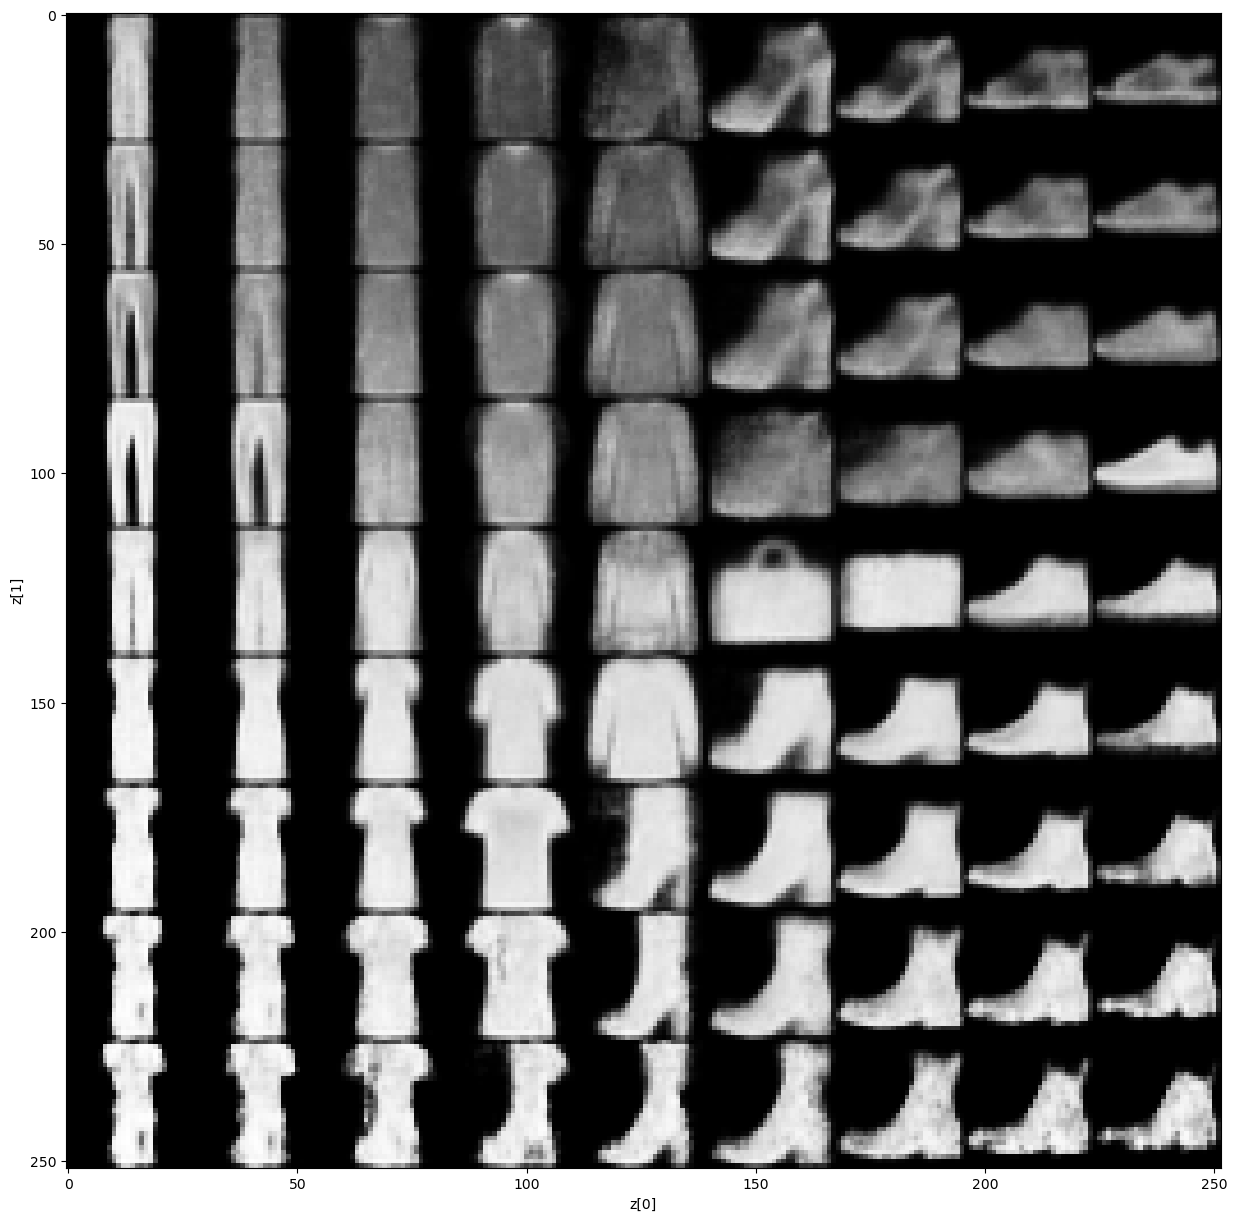

In [24]:
def plot_latent(encoder, decoder):
	n = 9
	img_dim = 28
	scale = 2.0
	figsize = 15
	figure = np.zeros((img_dim * n, img_dim * n))

	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			z_sample = np.array([[xi, yi]])
			x_decoded = decoder.predict(z_sample)
			images = x_decoded[0].reshape(img_dim, img_dim)
			figure[
				i * img_dim : (i + 1) * img_dim,
				j * img_dim : (j + 1) * img_dim,
			] = images

	plt.figure(figsize =(figsize, figsize))
	start_range = img_dim // 2
	end_range = n * img_dim + start_range + 1
	pixel_range = np.arange(start_range, end_range, img_dim)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	#plt.xticks(pixel_range, sample_range_x)
	#plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap ="Greys_r")
	plt.show()


plot_latent(encoder, decoder)

**The scatter plot of the Training data generated from the encoder has been generated to get a clear idea of the Latent Vector values.**

### (10) Visualization;

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


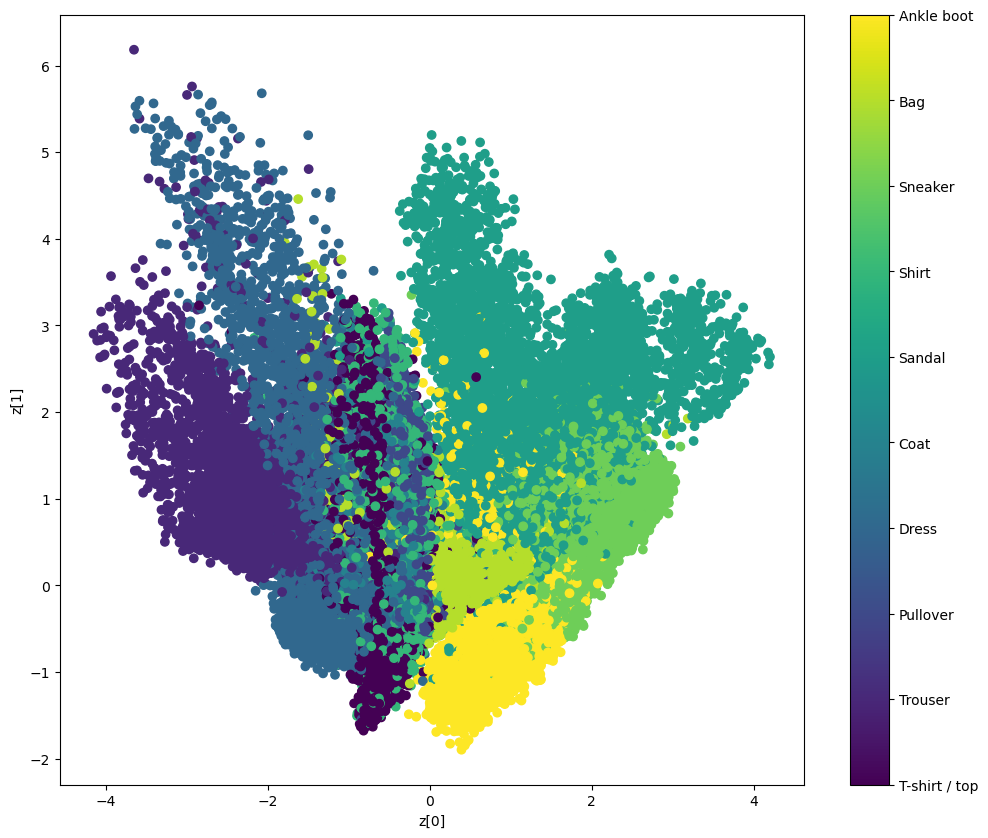

In [27]:
def plot_label_clusters(encoder, decoder, data, test_lab):
	z_mean, _, _ = encoder.predict(data)
	plt.figure(figsize =(12, 10))
	sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
	cbar = plt.colorbar(sc, ticks = range(10))
	cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)
